<a href="https://colab.research.google.com/github/d3dd/skunk-lm/blob/master/GonerFull24Feb2026.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/d3dd/skunk-lm/blob/master/Gonermab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goner genes – LOF-expression buffering & synthetic lethality in PAAD

**Pipeline summary**
1. Install dependencies
2. Upload input data files (once; guarded against re-upload)
3. Download Goner list from DepMap (Chronos Combined, common-essential)
4. Build LOF matrix from TCGA PAAD MAF (preserving Goner zero-columns)
5. Align with RNA-seq expression matrix
6. Spearman correlation + proper BH-FDR correction
7. Housekeeping gene filter (HOUNKPE / HRT Atlas; Hsiao)
8. Synthetic-lethality overlap
9. GO enrichment & visualisation

In [2]:
# ── 0. Dependencies ────────────────────────────────────────────────────────────
# Pin gseapy so enrichment_map is available and the API is stable.
!pip install -q pandas openpyxl scipy statsmodels lifelines requests
!pip install -q gseapy==1.1.3
!pip install -q biorosetta

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.0/350.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 553.0/553.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 3.1 MB/s eta 0:00:00


In [3]:
# ── 1. Upload input files (guarded – only prompts once per session) ─────────────
# Required files:
#   paad_expr_matrix.xlsx   – genes × samples RNA-seq matrix
#   paad_maaf.xlsx          – TCGA PAAD mutation annotation file

from google.colab import files as colab_files

REQUIRED = {'paad_expr_matrix.xlsx', 'paad_maaf.xlsx'}

try:
    uploaded  # already defined in this session?
    missing = REQUIRED - set(uploaded.keys())
    if missing:
        print(f'Still missing: {missing} – uploading now.')
        uploaded.update(colab_files.upload())
    else:
        print('✅ Input files already loaded:', list(uploaded.keys()))
except NameError:
    print('Please upload both files when prompted.')
    uploaded = colab_files.upload()

missing = REQUIRED - set(uploaded.keys())
if missing:
    raise FileNotFoundError(f'Required files not uploaded: {missing}')

Please upload both files when prompted.


Saving paad_expr_matrix.xlsx to paad_expr_matrix.xlsx
Saving paad_maaf.xlsx to paad_maaf.xlsx


## 2 – Goner list from DepMap

We download the DepMap gene-dependency summary and filter for genes marked *Common Essential* in the Chronos Combined dataset. The result is cached locally so the pipeline can be re-run without a network call.

In [4]:
# ── 2. Goner list from DepMap ──────────────────────────────────────────────────
import os
import pandas as pd

GONER_CACHE = 'goner_list.txt'

if os.path.exists(GONER_CACHE):
    goners = [l.strip() for l in open(GONER_CACHE) if l.strip()]
    print(f'✅ Loaded {len(goners)} Goner genes from cache.')
else:
    # DepMap public API – URL correct as of DepMap 23Q4.
    # If this fails, download manually from https://depmap.org/portal/download/
    # and place as 'gene_dep_summary.csv' in the working directory.
    DEPMAP_URL = 'https://depmap.org/portal/api/download/gene_dep_summary'
    try:
        dep = pd.read_csv(DEPMAP_URL)
    except Exception as e:
        raise RuntimeError(
            f'DepMap download failed ({e}). '
            'Download gene_dep_summary.csv manually from depmap.org and upload it.'
        )

    # The Dataset column contains the Python-enum string; strip the prefix.
    dep['Dataset_clean'] = dep['Dataset'].str.replace('DependencyEnum.', '', regex=False)
    print('Datasets available:', dep['Dataset_clean'].unique())

    mask = (
        dep['Dataset_clean'].str.contains('Chronos_Combined', case=False, na=False)
        & (dep['Common Essential'] == True)
    )
    goners = dep.loc[mask, 'Gene'].dropna().sort_values().unique().tolist()
    print(f'Found {len(goners)} Goner genes.')

    with open(GONER_CACHE, 'w') as fh:
        fh.writelines(g + '\n' for g in goners)
    print(f'✅ Saved to {GONER_CACHE}')

Datasets available: ['RNAi_merged' 'Chronos_Combined']
Found 1526 Goner genes.
✅ Saved to goner_list.txt


## 3 – LOF matrix

We keep only loss-of-function variant classes and pivot to a binary sample × gene matrix. Goner genes with **zero** LOF events are added as explicit zero columns, Done once and the matrix is not rebuilt later.

In [5]:
# ── 3. Build LOF matrix (single authoritative construction) ────────────────────
import io
import warnings
import numpy as np

warnings.simplefilter('ignore', category=pd.errors.PerformanceWarning)

LOF_TYPES = frozenset([
    'Frame_Shift_Del', 'Frame_Shift_Ins',
    'Nonsense_Mutation', 'Splice_Site',
    'Translation_Start_Site', 'Nonstop_Mutation',
])

maf = pd.read_excel(io.BytesIO(uploaded['paad_maaf.xlsx']), engine='openpyxl')
print(f'MAF shape: {maf.shape}')
print('Variant classes present:', maf['Variant_Classification'].unique())

maf_lof = maf[maf['Variant_Classification'].isin(LOF_TYPES)].copy()
print(f'LOF entries: {len(maf_lof)} / {len(maf)}')
print(f'Unique Hugo symbols in LOF: {maf_lof["Hugo_Symbol"].nunique()}')
print(f'Goner–LOF overlap: {len(set(maf_lof["Hugo_Symbol"]) & set(goners))}')

maf_lof_sub = maf_lof[['Tumor_Sample_Barcode', 'Hugo_Symbol']].drop_duplicates()
maf_lof_sub = maf_lof_sub.copy()
maf_lof_sub['Sample_ID'] = maf_lof_sub['Tumor_Sample_Barcode'].str[:12]

lof_matrix = (
    maf_lof_sub
    .assign(presence=1)
    .pivot_table(index='Sample_ID', columns='Hugo_Symbol',
                 values='presence', fill_value=0)
)

# Add zero-columns for Goners with no observed LOF events.
missing_goners = [g for g in goners if g not in lof_matrix.columns]
lof_matrix = lof_matrix.reindex(
    columns=lof_matrix.columns.tolist() + missing_goners, fill_value=0
)
print(f'LOF matrix shape (samples × genes): {lof_matrix.shape}')
print(f'  – {len(missing_goners)} Goner genes added as zero-columns')

lof_matrix.to_excel('tcga_goner_lof.xlsx')
print('✅ Saved tcga_goner_lof.xlsx')

MAF shape: (24849, 140)
Variant classes present: ['Missense_Mutation' 'Intron' 'Splice_Site' 'Nonsense_Mutation' 'Silent'
 'Frame_Shift_Del' 'Splice_Region' "3'Flank" 'Frame_Shift_Ins'
 'In_Frame_Del' 'RNA' "5'UTR" "3'UTR" "5'Flank" 'Nonstop_Mutation'
 'In_Frame_Ins' 'Translation_Start_Site']
LOF entries: 1872 / 24849
Unique Hugo symbols in LOF: 1599
Goner–LOF overlap: 126
LOF matrix shape (samples × genes): (151, 2999)
  – 1400 Goner genes added as zero-columns
✅ Saved tcga_goner_lof.xlsx


## 4 – RNA-seq alignment

In [6]:
# ── 4. Load RNA-seq, align samples ────────────────────────────────────────────
rna_raw = pd.read_excel(
    io.BytesIO(uploaded['paad_expr_matrix.xlsx']),
    engine='openpyxl',
    index_col=0,
)
print(f'RNA raw shape (genes × samples): {rna_raw.shape}')

# Transpose → samples × genes, truncate barcodes to 12-char case IDs.
rna = rna_raw.T.copy()
rna.index     = rna.index.str[:12]
lof_matrix.index = lof_matrix.index.str[:12]

# Remove duplicate case IDs (keep first occurrence).
rna        = rna.loc[~rna.index.duplicated()]
lof_matrix = lof_matrix.loc[~lof_matrix.index.duplicated()]

common = lof_matrix.index.intersection(rna.index)
print(f'Aligned samples after deduplication: {len(common)}')

lof_matrix = lof_matrix.loc[common]
rna        = rna.loc[common]

RNA raw shape (genes × samples): (60660, 182)
Aligned samples after deduplication: 143


## 5 – Spearman correlation + BH-FDR

We remove constant-variance genes (uninformative for correlation), compute Spearman ρ between per-sample LOF burden and each gene's expression, convert ρ to a t-statistic, and apply **Benjamini-Hochberg FDR** correction via `statsmodels`.

In [7]:
# ── 5. Spearman correlation + BH-FDR ──────────────────────────────────────────
from scipy.stats import t as t_dist
from statsmodels.stats.multitest import multipletests

# LOF burden = total LOF events per sample (Goner columns included).
lof_scores = lof_matrix.sum(axis=1).astype('float32')

# Filter constant genes.
expr = rna.astype('float32')
variances = expr.var(axis=0)
expr = expr.loc[:, variances > 0]
print(f'Removed {variances.size - expr.shape[1]} constant genes; {expr.shape[1]} remain.')

# Spearman ρ for every gene.
rho_series = expr.corrwith(lof_scores, method='spearman')

# Convert to two-sided p-values.
n  = len(common)
df = n - 2
t_stat = rho_series * np.sqrt(df / (1 - rho_series ** 2))
p_vals = 2 * t_dist.sf(np.abs(t_stat), df)

corr_df = pd.DataFrame({
    'Gene':    rho_series.index,
    'rho':     rho_series.values,
    'p_value': p_vals,
})

# Benjamini-Hochberg FDR (not rank/n, as used in another pipeline).
_, p_adj, _, _ = multipletests(corr_df['p_value'].fillna(1), method='fdr_bh')
corr_df['p_adj'] = p_adj

corr_sig = corr_df[(corr_df['rho'] > 0.3) & (corr_df['p_adj'] < 0.05)].copy()
print(f'Significant genes (ρ > 0.3, BH-FDR < 0.05): {len(corr_sig)}')

corr_df.to_csv('LOF_expression_correlations.csv', index=False)
corr_sig.to_csv('LOF_expression_correlations_significant.csv', index=False)
print('✅ Saved full and significant correlation tables.')

Removed 5787 constant genes; 54873 remain.
Significant genes (ρ > 0.3, BH-FDR < 0.05): 181
✅ Saved full and significant correlation tables.


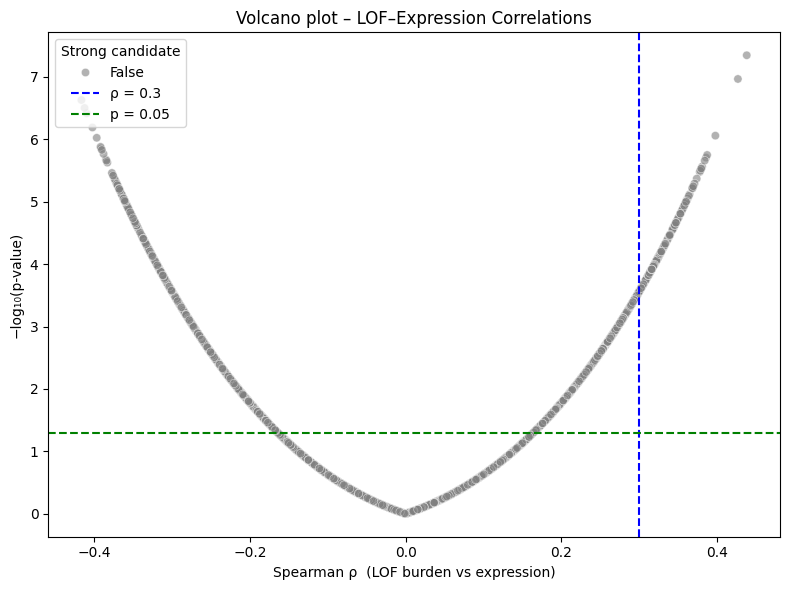

In [8]:
# ── 5b. Volcano plot ──────────────────────────────────────────────────────────
import matplotlib.pyplot as plt
import seaborn as sns

corr_df['neg_log10_p'] = -np.log10(corr_df['p_value'].clip(lower=1e-300))
corr_df['highlight']   = (corr_df['rho'] > 0.5) & (corr_df['p_adj'] < 0.01)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=corr_df, x='rho', y='neg_log10_p', hue='highlight',
    palette={True: 'red', False: 'grey'}, alpha=0.6,
)
plt.axvline(0.3,  color='blue',  linestyle='--', label='ρ = 0.3')
plt.axhline(-np.log10(0.05), color='green', linestyle='--', label='p = 0.05')
plt.xlabel('Spearman ρ  (LOF burden vs expression)')
plt.ylabel('−log₁₀(p-value)')
plt.title('Volcano plot – LOF–Expression Correlations')
plt.legend(title='Strong candidate', loc='upper left')
plt.tight_layout()
plt.show()

## 6 – Housekeeping gene filter

We load the HOUNKPE dataset (Human_Mouse_Common.csv from housekeeping.unicamp.br). A remote fetch is tried first; on SSL failure the user is prompted to upload the file manually. We also check against the Hsiao set from MSigDB. Both sets are loaded once and reused.

In [9]:
# ── 6a. Load HOUNKPE housekeeping genes ────────────────────────────────────────
import requests
from io import StringIO, BytesIO

HOUNKPE_URL = 'https://housekeeping.unicamp.br/Human_Mouse_Common.csv'

def _parse_hounkpe(df_raw):
    """Extract Human HGNC symbols from the HOUNKPE dataframe."""
    if df_raw.columns.tolist() == ['Mouse;Human']:
        split = df_raw['Mouse;Human'].str.split(';', expand=True)
        split.columns = ['Mouse', 'Human']
        df_raw = split
    return set(df_raw['Human'].dropna().str.strip().str.upper())

def load_hounkpe(url):
    try:
        resp = requests.get(url, timeout=15)
        resp.raise_for_status()
        raw = pd.read_csv(StringIO(resp.text))
        print('✅ HOUNKPE downloaded from remote URL.')
        return _parse_hounkpe(raw)
    except requests.exceptions.RequestException as e:
        print(f'⚠️  Network error ({type(e).__name__}) – please upload Human_Mouse_Common.csv manually.')
        print(f'    Download from: {url}')

    from google.colab import files as cf
    up = cf.upload()
    fname = next(iter(up))
    raw = pd.read_csv(BytesIO(up[fname]))
    print(f'✅ HOUNKPE loaded from uploaded file: {fname}')
    return _parse_hounkpe(raw)

housekeepers = load_hounkpe(HOUNKPE_URL)
print(f'HOUNKPE housekeeping genes: {len(housekeepers)}')

⚠️  Network error (SSLError) – please upload Human_Mouse_Common.csv manually.
    Download from: https://housekeeping.unicamp.br/Human_Mouse_Common.csv


Saving Human_Mouse_Common.csv to Human_Mouse_Common.csv
✅ HOUNKPE loaded from uploaded file: Human_Mouse_Common.csv
HOUNKPE housekeeping genes: 1129


In [10]:
# ── 6b. Load Hsiao housekeeping genes ─────────────────────────────────────────
# Download HSIAO_HOUSEKEEPING_GENES.v2023.2.Hs.tsv from:
#   https://www.gsea-msigdb.org/gsea/msigdb/human/geneset/HSIAO_HOUSEKEEPING_GENES.html
# and pair it to create HSIAO_Cleaned_paired_genes.csv with columns [Entrez ID, Gene Symbol].

try:
    hsiao_df = pd.read_csv('HSIAO_Cleaned_paired_genes.csv', sep=None, engine='python')
    hsiao_genes = set(
        hsiao_df['Gene Symbol'].dropna().astype(str).str.strip().str.upper()
    )
    print(f'✅ Hsiao housekeeping genes: {len(hsiao_genes)}')
except FileNotFoundError:
    print('⚠️  HSIAO_Cleaned_paired_genes.csv not found – skipping Hsiao filter.')
    hsiao_genes = set()

⚠️  HSIAO_Cleaned_paired_genes.csv not found – skipping Hsiao filter.


In [11]:
# ── 6c. Apply housekeeping filter ─────────────────────────────────────────────
all_hk = housekeepers | hsiao_genes
print(f'Combined housekeeping set: {len(all_hk)} genes')

corr_sig = corr_sig.copy()
corr_sig['Gene_up']       = corr_sig['Gene'].astype(str).str.upper()
corr_sig['Is_housekeeper'] = corr_sig['Gene_up'].isin(all_hk)
print(f'Housekeeping genes in corr_sig: {corr_sig["Is_housekeeper"].sum()} / {len(corr_sig)}')

corr_filtered = corr_sig[~corr_sig['Is_housekeeper']].copy()
print(f'Candidates after housekeeping exclusion: {len(corr_filtered)}')

Combined housekeeping set: 1129 genes
Housekeeping genes in corr_sig: 0 / 181
Candidates after housekeeping exclusion: 181


## 7 – Gene identifier mapping (Entrez → HGNC)

The expression matrix index is Entrez IDs; the SL database uses HGNC symbols. We convert once here using `biorosetta` and carry only the HGNC column forward.

> **Note on DepMap gene names**: DepMap's gene column may use the format `SYMBOL (EntrezID)`. The DepMap fetch in step 2 stores whatever string DepMap returns. If symbols and the SL database disagree, the overlap check below will catch it.

In [13]:
# ── 7. Entrez → HGNC mapping via biorosetta ────────────────────────────────────
import biorosetta as br

idmap  = br.IDMapper('all')
mapped = idmap.convert(
    corr_filtered['Gene'].tolist(), 'entr', 'symb', df=True
).rename(columns={'input': 'Gene', 'output': 'HGNC'})

corr_mapped = corr_filtered.merge(mapped[['Gene', 'HGNC']], on='Gene', how='inner')
corr_mapped['HGNC'] = corr_mapped['HGNC'].astype(str).str.upper()

print(f'Mapped: {corr_mapped.shape[0]} of {corr_filtered.shape[0]} Entrez IDs → HGNC')
corr_mapped.to_csv('corr_mapped_entrez_to_hgnc.csv', index=False)
print('✅ Saved corr_mapped_entrez_to_hgnc.csv')

- Biomart data has not been downloaded yet.
- Downloading up-to-date gene annotation data from Ensembl Biomart (http://www.ensembl.org/biomart) to /usr/local/lib/python3.12/dist-packages/biorosetta/data/ensembl.tsv.
- This operation has to be performed only once and it lasts less than few minutes.


/usr/local/lib/python3.12/dist-packages/biorosetta/data/ensembl.tsv: 58.8MiB [04:25, 232kiB/s] 


- Download completed
- Biomart data has not been downloaded yet.
- Downloading up-to-date gene annotation data from HGNC Biomart (http://biomart.genenames.org) to /usr/local/lib/python3.12/dist-packages/biorosetta/data/hgnc.tsv.
- This operation has to be performed only once and it lasts less than few minutes.


/usr/local/lib/python3.12/dist-packages/biorosetta/data/hgnc.tsv: 100%|██████████| 17.0/17.0 [00:00<00:00, 23.1kiB/s]
INFO:biothings.client:querying 1-181 ...


- Download completed
Mapped: 235 of 181 Entrez IDs → HGNC
✅ Saved corr_mapped_entrez_to_hgnc.csv


/usr/local/lib/python3.12/dist-packages/biorosetta/classes.py:365: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  id_list_out[idx] = out_df.loc[idx, src_ids[i]]
/usr/local/lib/python3.12/dist-packages/biorosetta/classes.py:365: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  id_list_out[idx] = out_df.loc[idx, src_ids[i]]


## 8 – Synthetic-lethality overlap

We load the curated SL database and find the set of genes that are SL partners of any Goner. The final candidates are the intersection of that set with our housekeeping-filtered, HGNC-mapped correlation hits.

> Upload `gene_sl_gene.csv` when prompted below.

In [14]:
# ── 8a. Load SL database ──────────────────────────────────────────────────────
import os

if not os.path.exists('gene_sl_gene.csv'):
    from google.colab import files as cf
    print('Please upload gene_sl_gene.csv')
    cf.upload()

sl_df = pd.read_csv('gene_sl_gene.csv')
sl_df['x_name'] = sl_df['x_name'].astype(str).str.upper()
sl_df['y_name'] = sl_df['y_name'].astype(str).str.upper()
print(f'SL database: {sl_df.shape[0]} interactions, columns: {sl_df.columns.tolist()}')

Please upload gene_sl_gene.csv


Saving gene_sl_gene.csv to gene_sl_gene.csv
SL database: 37943 interactions, columns: ['x.START_ID', 'x_type', 'x_name', 'x_source', 'y.END_ID', 'y_type', 'y_name', 'y_source', 'relation', 'X.TYPE', 'rel_source', 'edge_index', 'cell_line', 'pubmed_id', 'cancer']


In [15]:
# ── 8b. Goners in SL data & SL partners ──────────────────────────────────────
goners_upper = [str(g).upper() for g in goners]

x_set = set(sl_df['x_name'])
y_set = set(sl_df['y_name'])

goners_in_sl = set(goners_upper) & (x_set | y_set)
print(f'Goners present in SL database: {len(goners_in_sl)}')

sl_partners = (
    set(sl_df.loc[sl_df['x_name'].isin(goners_upper), 'y_name'])
    | set(sl_df.loc[sl_df['y_name'].isin(goners_upper), 'x_name'])
)
print(f'SL partners of Goners: {len(sl_partners)}')

# Diagnostic: corr_mapped HGNC overlap with SL partner set
corr_hgnc_set = set(corr_mapped['HGNC'])
print(f'Overlap with corr_mapped HGNC: {len(corr_hgnc_set & sl_partners)}')

Goners present in SL database: 1275
SL partners of Goners: 3899
Overlap with corr_mapped HGNC: 36


In [16]:
# ── 8c. Final candidate list ───────────────────────────────────────────────────
# biorosetta can map one Entrez ID to several HGNC symbols (one-to-many),
# producing duplicate HGNC rows with different ρ values.  We keep the
# highest-ρ row per HGNC symbol so each gene appears exactly once.
final_raw = corr_mapped[corr_mapped['HGNC'].isin(sl_partners)].copy()
print(f'Rows before HGNC deduplication: {final_raw.shape[0]}')

final = (
    final_raw
    .sort_values('rho', ascending=False)
    .drop_duplicates(subset='HGNC', keep='first')
    .reset_index(drop=True)
)
print(f'🎯 Final buffering candidates (SL-overlap, deduplicated): {final.shape[0]} genes')
print(final[['Gene', 'HGNC', 'rho', 'p_adj']].to_string(index=False))

final.to_csv('buffering_candidates_curatedSL.csv', index=False)
print('✅ Saved buffering_candidates_curatedSL.csv')

Rows before HGNC deduplication: 45
🎯 Final buffering candidates (SL-overlap, deduplicated): 36 genes
 Gene     HGNC      rho    p_adj
 4002     LMNA 0.373699 0.008060
 2356     FPGS 0.368002 0.008060
 5573  PRKAR1A 0.361947 0.008698
   26     AOC1 0.359921 0.008698
  313     AOAH 0.358395 0.008904
  403     ARL3 0.357646 0.008904
  834    CASP1 0.356301 0.008954
 1103     CHAT 0.352992 0.009709
  575   ADGRB1 0.352337 0.009709
 5426     POLE 0.347739 0.010268
 2870     GRK6 0.346697 0.010268
 2657     GDF1 0.342151 0.011217
   13    AADAC 0.333448 0.014611
  358     AQP1 0.332765 0.014652
  663    BNIP2 0.327714 0.015955
   21    ABCA3 0.327707 0.015955
 2625    GATA3 0.327264 0.015955
 6106   PRPF31 0.324689 0.016868
 2806     GOT2 0.324655 0.016868
 1809   DPYSL3 0.324170 0.016879
 8348   H2BC17 0.324129 0.016879
  587    BCAT2 0.324057 0.016879
 2287    FKBP3 0.322082 0.017529
 3076      CFH 0.321748 0.017715
   95     ACY1 0.320904 0.018072
  995   CDC25C 0.316061 0.019973
 5268 SE

## 9 – GO enrichment & visualisation

In [17]:
# ── 9a. GO Biological Process enrichment ──────────────────────────────────────
# Note on Enrichr p-values: with small gene lists, BH-adjusted p-values from
# Enrichr tend to cluster at the significance boundary (all ~0.05).  This is
# expected behaviour, not a bug.  The Combined Score (−log p × z-score from
# perturbation experiments) is the more discriminating ranking metric here.
import gseapy as gp

# Build gene list: drop anything that is null, numeric, or placeholder.
raw_hgnc = final['HGNC'].dropna().astype(str).str.strip().str.upper()
sig_genes = [
    g for g in raw_hgnc.unique()
    if g not in ('NAN', '', 'NONE') and not g.isnumeric()
]
print(f'Input gene list ({len(sig_genes)} unique HGNC symbols):')
print(sig_genes)

if len(sig_genes) == 0:
    raise ValueError(
        'Gene list is empty after cleaning. '
        'Check that biorosetta produced valid HGNC symbols in final["HGNC"].'
    )

enr = gp.enrichr(
    gene_list=sig_genes,
    gene_sets=['GO_Biological_Process_2021'],
    organism='Human',
    cutoff=0.05,
    outdir=None,
)
enr_res = enr.results

sig_res = enr_res[enr_res['Adjusted P-value'] < 0.05]
print(f'\nSignificant GO terms (adj-p < 0.05): {len(sig_res)}')

if len(sig_res) == 0:
    print('⚠️  No significant GO terms found.  Showing top 10 by Combined Score regardless:')
    enr_res = enr_res.sort_values('Combined Score', ascending=False)
else:
    enr_res = sig_res.sort_values('Combined Score', ascending=False)

print(enr_res[['Term', 'Adjusted P-value', 'Combined Score', 'Genes']].head(10).to_string(index=False))

enr_res.to_csv('SL_overlap_enrichment_results.csv', index=False)
print('\n✅ Saved SL_overlap_enrichment_results.csv')

Input gene list (36 unique HGNC symbols):
['LMNA', 'FPGS', 'PRKAR1A', 'AOC1', 'AOAH', 'ARL3', 'CASP1', 'CHAT', 'ADGRB1', 'POLE', 'GRK6', 'GDF1', 'AADAC', 'AQP1', 'BNIP2', 'ABCA3', 'GATA3', 'PRPF31', 'GOT2', 'DPYSL3', 'H2BC17', 'BCAT2', 'FKBP3', 'CFH', 'ACY1', 'CDC25C', 'SERPINB5', 'KMT2D', 'CRP', 'ATP6AP1', 'NONO', 'ACADL', 'ACAT1', 'TNFRSF1A', 'LCK', 'GCK']

Significant GO terms (adj-p < 0.05): 11
                                                    Term  Adjusted P-value  Combined Score                     Genes
            cellular response to copper ion (GO:0071280)          0.047684      520.808962                 AOC1;AQP1
branched-chain amino acid catabolic process (GO:0009083)          0.047684      485.056501               ACAT1;BCAT2
branched-chain amino acid metabolic process (GO:0009081)          0.047684      485.056501               ACAT1;BCAT2
   cellular response to inorganic substance (GO:0071241)          0.047684      453.393951                 AOC1;AQP1
             

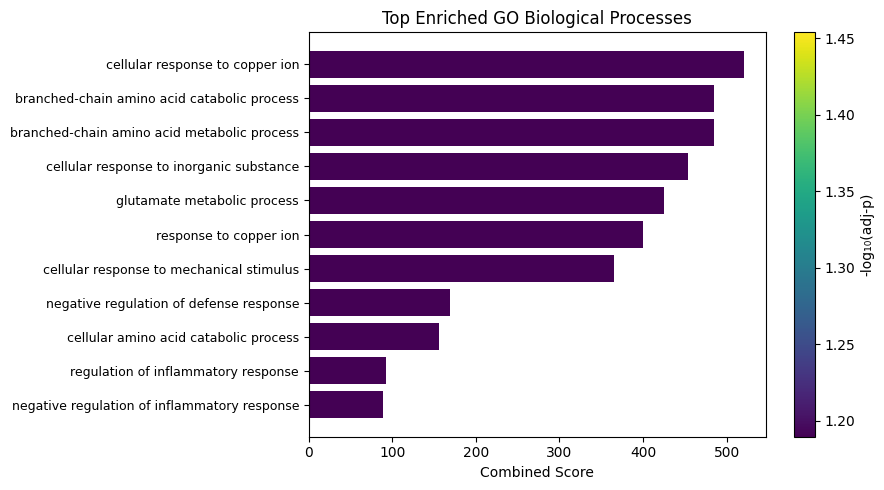

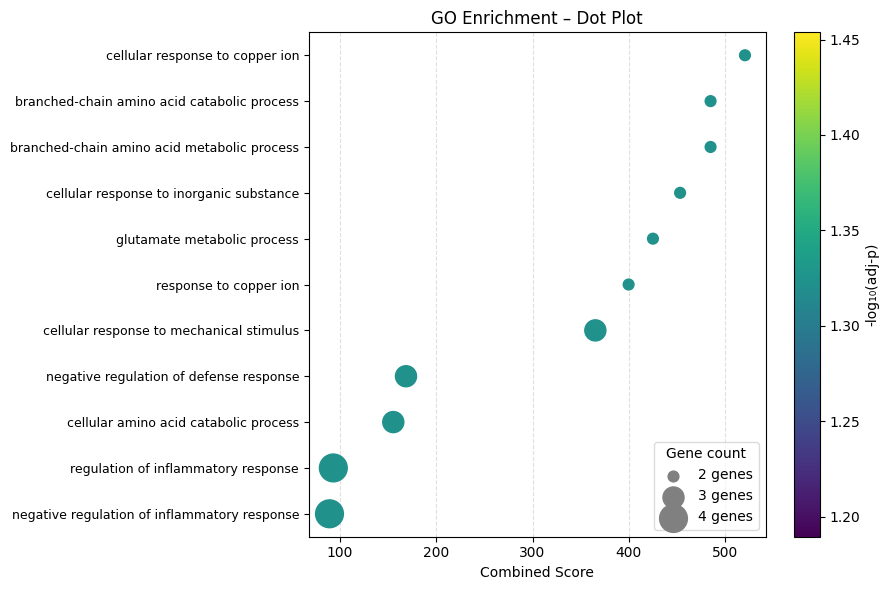

✅ Saved enrichment_barplot.png and enrichment_dotplot.png


In [26]:
# ── 9b. Plots ─────────────────────────────────────────────────────────────────
# gseapy's dotplot silently drops dots with very small gene ratios (< threshold),
# causing terms with only 2 gene hits to disappear even when their Combined Score
# is the highest.  We draw both plots manually so every term is visible.
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

plot_df = enr_res.copy().reset_index(drop=True)

# Parse gene count from Overlap column (defensive, as before).
overlap_col = next((c for c in plot_df.columns if 'overlap' in c.lower()), None)
if overlap_col:
    plot_df['_gene_count'] = plot_df[overlap_col].str.split('/').str[0].astype(int)
else:
    plot_df['_gene_count'] = plot_df['Genes'].str.split(';').str.len()

# Shorten long GO term labels for readability.
plot_df['_label'] = plot_df['Term'].str.replace(r'\s*\(GO:\d+\)', '', regex=True)

# Colour by -log10(adj-p); size by gene count.
log_p = -np.log10(plot_df['Adjusted P-value'].clip(lower=1e-300))
norm  = plt.Normalize(log_p.min(), log_p.max())
colours = cm.viridis(norm(log_p))
# Scale dot area: min 60, max 400 based on gene count.
gc = plot_df['_gene_count']
sizes = 60 + 340 * (gc - gc.min()) / max(gc.max() - gc.min(), 1)

# ── Bar plot ──────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(9, 5))
y_pos = range(len(plot_df))
bars  = ax.barh(list(y_pos), plot_df['Combined Score'], color=colours)
ax.set_yticks(list(y_pos))
ax.set_yticklabels(plot_df['_label'], fontsize=9)
ax.invert_yaxis()
ax.set_xlabel('Combined Score')
ax.set_title('Top Enriched GO Biological Processes')
sm = cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='-log₁₀(adj-p)')
plt.tight_layout()
plt.savefig('enrichment_barplot.png', dpi=150)
plt.show()

# ── Dot plot ──────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(9, 6))
sc = ax.scatter(
    plot_df['Combined Score'],
    list(y_pos),
    s=sizes,
    c=log_p,
    cmap='viridis',
    zorder=3,
)
ax.set_yticks(list(y_pos))
ax.set_yticklabels(plot_df['_label'], fontsize=9)
ax.invert_yaxis()
ax.set_xlabel('Combined Score')
ax.set_title('GO Enrichment – Dot Plot')
ax.grid(axis='x', linestyle='--', alpha=0.4)
fig.colorbar(sc, ax=ax, label='-log₁₀(adj-p)')
# Size legend.
for n in sorted(gc.unique()):
    s = 60 + 340 * (n - gc.min()) / max(gc.max() - gc.min(), 1)
    ax.scatter([], [], s=s, c='grey', label=f'{n} gene{"s" if n>1 else ""}')
ax.legend(title='Gene count', loc='lower right', framealpha=0.7)
plt.tight_layout()
plt.savefig('enrichment_dotplot.png', dpi=150)
plt.show()
print('✅ Saved enrichment_barplot.png and enrichment_dotplot.png')

In [27]:
# ── 9c. Enrichment map (network) ──────────────────────────────────────────────
from gseapy import enrichment_map

nodes, edges = enrichment_map(enr_res)
nodes.to_csv('em_nodes.csv', index=False)
edges.to_csv('em_edges.csv', index=False)
print(f'Enrichment map: {len(nodes)} nodes, {len(edges)} edges')

Enrichment map: 10 nodes, 13 edges


/usr/local/lib/python3.12/dist-packages/gseapy/plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/usr/local/lib/python3.12/dist-packages/gseapy/plot.py:694: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(


In [28]:
# ── 9d. LaTeX table for Overleaf ──────────────────────────────────────────────
# Identify the overlap/gene-count column defensively (name varies by gseapy version).
overlap_col = next((c for c in enr_res.columns if 'overlap' in c.lower()), None)
if overlap_col:
    enr_res['Gene count'] = enr_res[overlap_col].str.split('/').str[0].astype(int)
else:
    # Fall back: count genes in the 'Genes' column
    enr_res['Gene count'] = enr_res['Genes'].str.split(';').str.len()

top10 = enr_res[['Term', 'Gene count', 'Adjusted P-value', 'Combined Score']].head(10).copy()

# Sanitise term strings for LaTeX (& _ % $ # { } ~ ^ \ are special).
def tex_escape(s):
    for ch, rep in [('&', r'\&'), ('%', r'\%'), ('_', r'\_'), ('#', r'\#')]:
        s = s.replace(ch, rep)
    return s

top10['Term'] = top10['Term'].apply(tex_escape)

latex_str = top10.to_latex(
    index=False,
    escape=False,          # we escaped manually above
    column_format='p{7cm}rr>{\\raggedleft\\arraybackslash}p{2cm}',
    float_format='%.4f',
    caption='Top 10 enriched GO Biological Process terms for SL-overlap buffering candidates, '
            'ranked by Combined Score.',
    label='tab:go_enrichment',
    position='ht',
)

# Write to file for reliable download.
with open('go_enrichment_table.tex', 'w') as fh:
    fh.write(latex_str)
print('✅ Saved go_enrichment_table.tex')
print()
print(latex_str)

✅ Saved go_enrichment_table.tex

\begin{table}[ht]
\caption{Top 10 enriched GO Biological Process terms for SL-overlap buffering candidates, ranked by Combined Score.}
\label{tab:go_enrichment}
\begin{tabular}{p{7cm}rr>{\raggedleft\arraybackslash}p{2cm}}
\toprule
Term & Gene count & Adjusted P-value & Combined Score \\
\midrule
cellular response to copper ion (GO:0071280) & 2 & 0.0477 & 520.8090 \\
branched-chain amino acid catabolic process (GO:0009083) & 2 & 0.0477 & 485.0565 \\
branched-chain amino acid metabolic process (GO:0009081) & 2 & 0.0477 & 485.0565 \\
cellular response to inorganic substance (GO:0071241) & 2 & 0.0477 & 453.3940 \\
glutamate metabolic process (GO:0006536) & 2 & 0.0477 & 425.1782 \\
response to copper ion (GO:0046688) & 2 & 0.0477 & 399.8926 \\
cellular response to mechanical stimulus (GO:0071260) & 3 & 0.0477 & 365.3194 \\
negative regulation of defense response (GO:0031348) & 3 & 0.0477 & 168.5328 \\
cellular amino acid catabolic process (GO:0009063) & 3 & 

In [29]:
# ── 10. Download all outputs ───────────────────────────────────────────────────
from google.colab import files as cf

outputs = [
    'goner_list.txt',
    'tcga_goner_lof.xlsx',
    'LOF_expression_correlations.csv',
    'LOF_expression_correlations_significant.csv',
    'corr_mapped_entrez_to_hgnc.csv',
    'buffering_candidates_curatedSL.csv',
    'SL_overlap_enrichment_results.csv',
    'enrichment_barplot.png',
    'enrichment_dotplot.png',
    'em_nodes.csv',
    'em_edges.csv',
]

for f in outputs:
    if os.path.exists(f):
        cf.download(f)
    else:
        print(f'⚠️  {f} not found – skipping.')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>